In [68]:
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import petl as etl
import h5py
import zarr
import dask
import seaborn as sns
import sys
import malariagen_data
import collections
import random
import os
import functools

In [69]:
from dask.diagnostics import ProgressBar
# quieten dask warnings about large chunks
ProgressBar().register()
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [70]:
def log(*msg):
    print(' '.join(map(str, msg)), file=sys.stdout)
    sys.stdout.flush()

In [71]:
def subplots(*args, despine=None, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    if despine is None:
        despine = dict(offset=10, trim=False)
    if hasattr(ax, '__len__'):
        for a in ax:
            sns.despine(ax=a, **despine)
    else:
        sns.despine(ax=ax, **despine)
    return fig, ax

--------------------

In [122]:
order = ['BFcol', 'MAcol', 'CIcol', 'GHcol','GHgam', 'GNgam', 'MAgam','BFgam', 'gcx2','gcx1-GW', 'gcx1-GM']

In [123]:
fst = pd.read_csv("/mnt/c/Users/rando/Documenti/Ag1000G/Data/fst/fst_nogncol.csv",sep="\t", names=['region','pop1','pop2','fst', 'se']).drop(columns=["region"])
fst

,pop1,pop2,fst,se
0,gcx1-GM,BFcol,0.028,0.0015
1,gcx1-GM,CIcol,0.034,0.0013
2,gcx1-GM,GHcol,0.033,0.0016
3,gcx1-GM,MAcol,0.028,0.0015
4,gcx1-GW,BFcol,0.018,0.0013
...,...,...,...,...
105,GHcol,CIcol,0.008,0.0003
106,GHcol,MAcol,0.010,0.0004
107,MAcol,BFcol,0.000,0.0000
108,MAcol,CIcol,0.010,0.0003


In [124]:
fst.fst = pd.to_numeric(fst['fst'], errors='coerce')
df = fst.pivot(index='pop1', columns='pop2', values='fst')[order]
df = df.fillna(df.T).loc[order]

In [125]:
df

pop2,BFcol,MAcol,CIcol,GHcol,GHgam,GNgam,MAgam,BFgam,gcx2,gcx1-GW,gcx1-GM
pop1,,,,,,,,,,,
BFcol,NaN,0.000,0.010,0.010,0.031,0.030,0.029,0.030,0.010,0.018,0.028
MAcol,0.000,NaN,0.010,0.010,0.031,0.029,0.029,0.029,0.010,0.018,0.028
CIcol,0.010,0.010,NaN,0.008,0.041,0.040,0.039,0.039,0.015,0.024,0.034
GHcol,0.010,0.010,0.008,NaN,0.040,0.039,0.039,0.039,0.014,0.023,0.033
GHgam,0.031,0.031,0.041,0.040,NaN,0.005,0.006,0.004,0.036,0.028,0.033
GNgam,0.030,0.029,0.040,0.039,0.005,NaN,0.003,0.001,0.035,0.027,0.032
MAgam,0.029,0.029,0.039,0.039,0.006,0.003,NaN,0.002,0.034,0.027,0.032
BFgam,0.030,0.029,0.039,0.039,0.004,0.001,0.002,NaN,0.034,0.026,0.031
gcx2,0.010,0.010,0.015,0.014,0.036,0.035,0.034,0.034,NaN,0.009,0.020


/tmp/ipykernel_23290/1699606632.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')


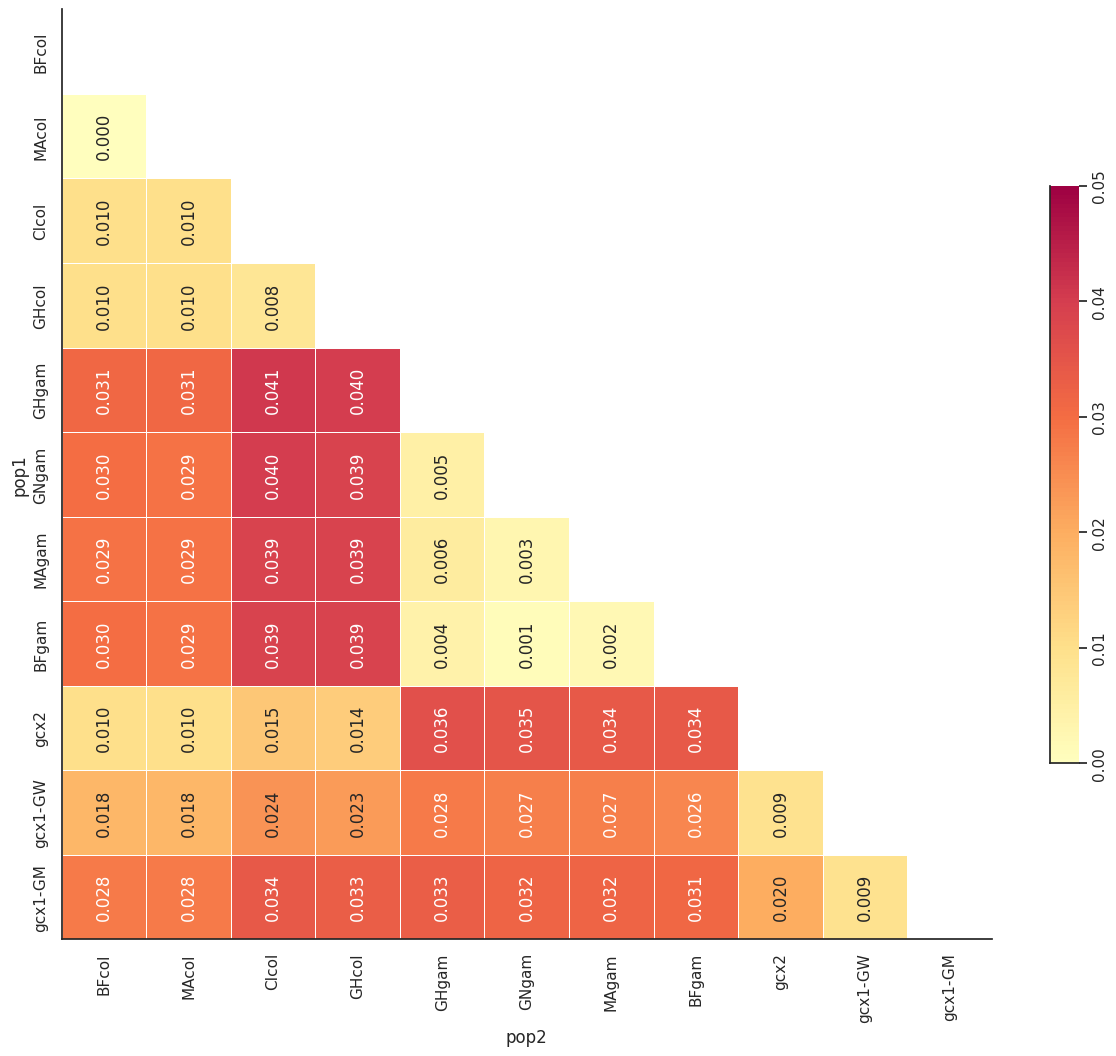

In [126]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.color_palette("Spectral_r", n_colors=3, as_cmap=True)
ax.invert_yaxis()
# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(df, mask=mask, cmap=cmap, vmax=.05, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f', annot_kws={"size":12, "rotation":90}, ax=ax)
cbar = heatmap.collections[0].colorbar
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=90)
#sns.set(font_scale = 1)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
sns.set_style("white")
sns.despine()
f.savefig('fst.png', dpi=300)